**Submitted by : Akshay Bajpai**

**subject : Deep Learning & Intelligent Systems**

**Study group: KNSSh-11f**

**Institute: ICNI**

In [38]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

from tensorflow.compat.v1.keras.layers import BatchNormalization

In [39]:
def list_images(basePath, contains=None):
    
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        
        for filename in filenames:
            
        
            if contains is not None and filename.find(contains) == -1:
                continue

            
            ext = filename[filename.rfind("."):].lower()

            
            if ext.endswith(validExts):
                
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath
                
def load_images(directory='', size=(64,64)):
    images = []
    labels = []  
    label = 0
    
    imagePaths = list(list_images(directory))
    
    for path in imagePaths:
        
        if not('OSX' in path):
        
            path = path.replace('\\','/')

            image = cv2.imread(path) 
            image = cv2.resize(image,size) 

            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    return images

In [40]:
images=load_images('data/data')

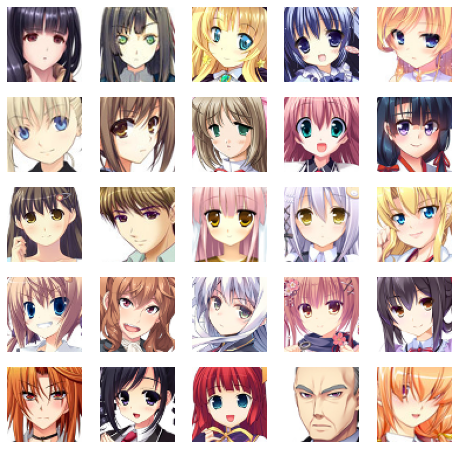

In [41]:
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

In [42]:
class GAN():
    def __init__(self):
        self.img_shape = (64, 64, 3)
        
        self.noise_size = 100

        optimizer = Adam(0.0002,0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        self.discriminator.trainable = False
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined.summary()
        
    
    def build_generator(self):
        epsilon = 0.00001 
        noise_shape = (self.noise_size,)
        
        model = Sequential()
        
        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))
        
        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

        
        model.add(Activation("tanh"))
        
        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, metrics_update=50, save_images=100, save_model=2000):

        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)
        
        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)

            
            
            
            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            
            noise = np.random.normal(0, 1, (batch_size, self.noise_size))

            valid_y = np.array([1] * batch_size)
            g_loss = self.combined.train_on_batch(noise, valid_y)
            
            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss
            
            
            
            if epoch % metrics_update == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/metrics_update, 100*mean_d_loss[1]/metrics_update, mean_g_loss/metrics_update))
                mean_d_loss=[0,0]
                mean_g_loss=0
            
            
            if epoch % save_images == 0:
                self.save_images(epoch)
            
            
            
            if epoch % save_model == 0:
                self.generator.save("generator_%d" % epoch)
                self.discriminator.save("discriminator_%d" % epoch)

    
    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        
        
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()
        
        fig.savefig("animeGenerated/Faces_%d.png" % epoch)
        plt.close()

In [43]:

!mkdir animeGenerated

mkdir: cannot create directory ‘animeGenerated’: File exists


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_16 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_17 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                     

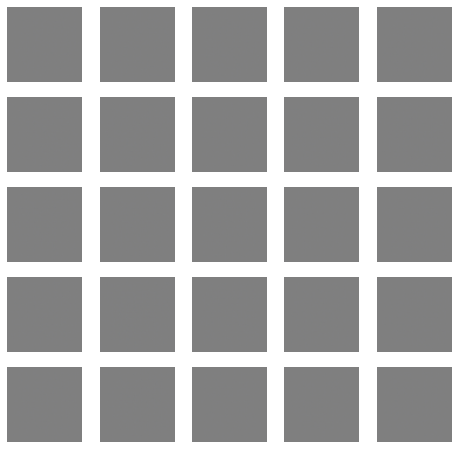

INFO:tensorflow:Assets written to: generator_0/assets


INFO:tensorflow:Assets written to: generator_0/assets


INFO:tensorflow:Assets written to: discriminator_0/assets


INFO:tensorflow:Assets written to: discriminator_0/assets


200 [Discriminator loss: 0.356870, acc.: 86.38%] [Generator loss: 3.495172]
400 [Discriminator loss: 0.390841, acc.: 82.59%] [Generator loss: 3.148294]
600 [Discriminator loss: 0.310479, acc.: 87.05%] [Generator loss: 3.646496]
800 [Discriminator loss: 0.353700, acc.: 84.74%] [Generator loss: 3.847828]
1000 [Discriminator loss: 0.262744, acc.: 89.27%] [Generator loss: 3.787819]


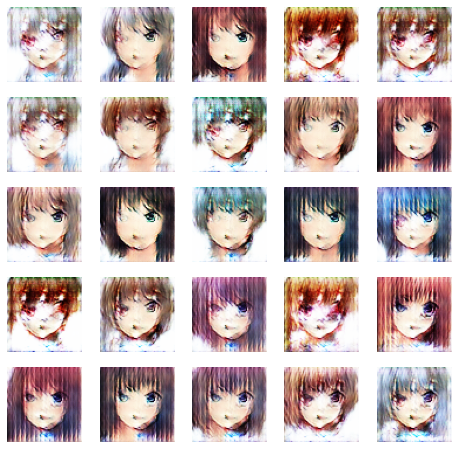

In [44]:
gan=GAN()
gan.train(epochs=15001, batch_size=256, metrics_update=200, save_images=1000, save_model=15000)